## File Name Consistency

In [1]:
import os, re

DATA_DIR = "07_stimuli"  # Directory with the audio files

files = os.listdir(DATA_DIR)

# rename the files (do only once...)
# Filenaming convention: {position}_{speaker_id}_{turn}
for filename in files:
    if "_group_" in filename:
        new_filename = re.sub("group_", "", filename)
        new_filename = re.sub("_booth_", "", new_filename)
        os.rename(os.path.join(DATA_DIR, filename), os.path.join(DATA_DIR, new_filename))


## Checkout the Data

In [2]:
# Check the content
speakers = set([filename.split("_")[1] for filename in files])
print("Number of Sound Snipptes: ", len(files))
print("Number of speakers: ", len(speakers))
print("Speaker IDs: ", speakers)

Number of Sound Snipptes:  195
Number of speakers:  8
Speaker IDs:  {'32', '34', '31', '21', '22', '33', '25', '24'}


## Plot the Distribution of Speakers and Snippets

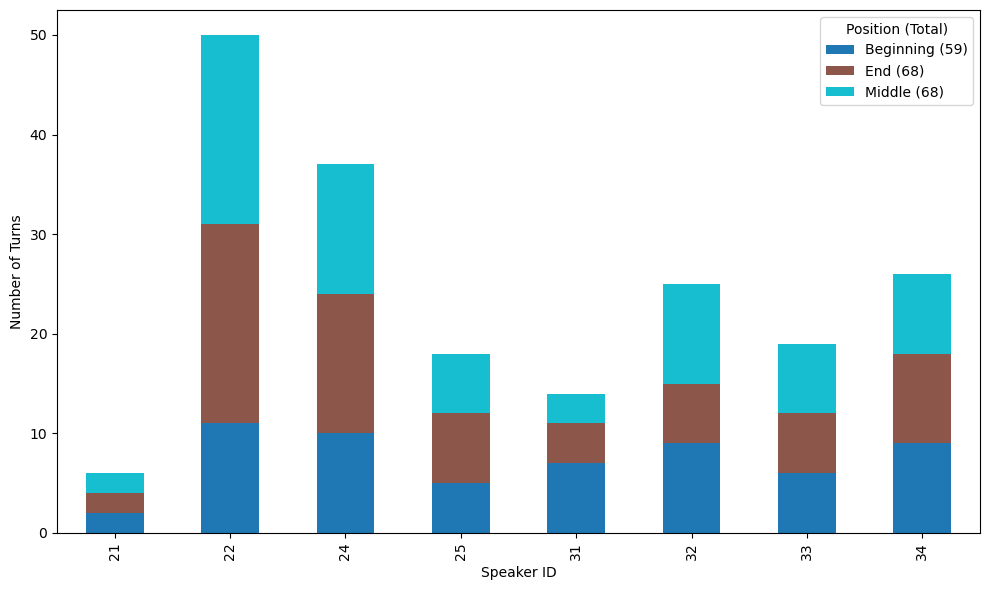

In [40]:
import pandas as pd
from scripts.plot_utils import plot_speaker_distr

# make an index of all the data we have
index_df = pd.DataFrame(columns=["pos", "speaker", "turn"])
for file in files:
    name = file.split(".")[0]
    pos, speaker, turn = name.split("_")
    index_df.loc[len(index_df)] = [pos, speaker, turn]

plot_speaker_distr(index_df)


# Inspect the dataset of stimuli


## Combine the Snippets into pairs
- Creating an Index for the stimuli we get.
- Upsampling the target class ("same"), by including both orders

In [38]:
from scripts.data_prep import generate_stimuli_index

# Downsample to have for each position the same amount of data:
min_count = index_df['pos'].value_counts().min()
index_df = (
    index_df.groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

# Index the Stimuli
beginning_stimuli_index = generate_stimuli_index(index_df, "b")
middle_stimuli_index = generate_stimuli_index(index_df, "m")
end_stimuli_index = generate_stimuli_index(index_df, "e")

In [39]:
stimuli_dfs = [beginning_stimuli_index, middle_stimuli_index, end_stimuli_index]

for df in stimuli_dfs:
    print(df.groupby("condition").count()["speaker1"])

condition
different    1492
same          438
Name: speaker1, dtype: int64
condition
different    1454
same          514
Name: speaker1, dtype: int64
condition
different    1443
same          536
Name: speaker1, dtype: int64


# Results

Table with the results from the whole dataset (without noise)

In [64]:
import pandas as pd

results = pd.read_csv("results/allClasses_folds-5_False_pos-all.csv")
results = results.round(2).astype(str)
print(results.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Unnamed: 0 & precision & recall & f1-score & support \\
\midrule
different & 0.89 & 0.99 & 0.94 & 877.8 \\
same & 0.97 & 0.64 & 0.77 & 297.6 \\
macro avg & 0.93 & 0.82 & 0.86 & 1175.4 \\
weighted avg & 0.91 & 0.91 & 0.9 & 1175.4 \\
\bottomrule
\end{tabular}



In [60]:
noise = False
summary = {"pos":[]}
pos_dfs = {}
for pos in ["b", "m", "e"]:
    df = pd.read_csv(f"results/onlyTarget_folds-5_{noise}_pos-{pos}.csv")
    pos_dfs[pos] = df
    summary["pos"].append(pos)
    for column in df.columns:
        if column in ["Unnamed: 0", 'fold']:
            continue
        if column in summary:
            summary[column].append(df[column].mean())
        else:
            summary[column] = [df[column].mean()]
summary_df = pd.DataFrame(summary)
summary_df

,pos,precision,recall,f1-score,support,total
0,b,0.978151,0.689446,0.807640,87.6,386.0
1,m,0.987837,0.791871,0.878567,102.8,393.6
2,e,1.000000,0.813413,0.897046,107.2,395.8


<Figure size 600x600 with 0 Axes>

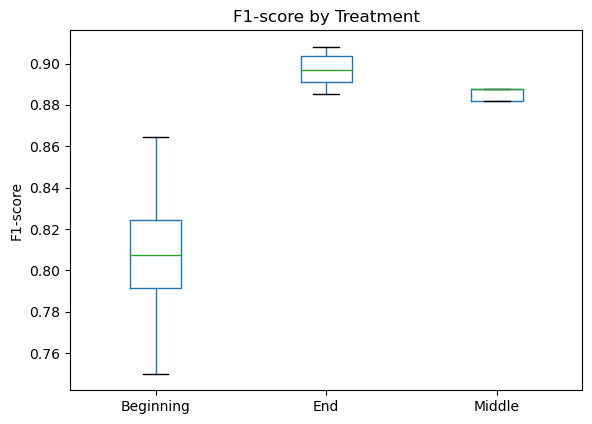

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new DataFrame with f1-score and treatment label
f1_data = pd.DataFrame({
    'f1-score': pd.concat([pos_dfs["b"]['f1-score'], pos_dfs["m"]['f1-score'], pos_dfs["e"]['f1-score']], ignore_index=True),
    'treatment': (['Beginning'] * len(pos_dfs["b"])) + (['Middle'] * len(pos_dfs["m"])) + (['End'] * len(pos_dfs["e"]))
})

# Plot the boxplot
plt.figure(figsize=(6, 6))
f1_data.boxplot(column='f1-score', by='treatment', showfliers=False)
plt.title('F1-score by Treatment')
plt.suptitle('')  # Remove default pandas title
plt.xlabel('')
plt.ylabel('F1-score')
plt.grid(False)
plt.show()

# Appendix

In [ ]:
# might need this later, for dependency problems
%pip install --upgrade librosa numba numpy lazy_loader



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 903.1 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 1.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 2.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.40.0
    Uninstalling llvmlite-0.40.0:
      Successfully uninstalled llvmlite-0.40.0
  Attempting uninstall: lazy_loader
    Found existing installation: lazy_loader 0.2
    Uninstalling lazy_loader-0.2:
      Successfully uninstalled lazy_loader-0.2
  A